#  Probabilistic Matrix Factorization of the MovieLens Ratings

Something something . Matrix factorization is a simple and powerful technique for predicting user's ratings of items using embedding in a latent space.

Modern methods have many useful adaptations, but the general system predicts user $u$'s rating of item $i$, $r_{u,i}$  as 
  *  $r_{u,i} = \mu + \beta_u + \beta_i + \vec{v}_u^T \cdot \vec{v}_i^T$
  *  $\mu$, $\beta_u$, and $\beta_i$ are overall mean ratings and offsets for users and movies
  *  $\vec{v}_i, \vec{v}_u \in \mathbb{R}^K$ are the user's and movie's embeddings in a $K$ dimensional space.
  *  We regularize user and item vectors by modeling them as coming from a multivariate gaussian, which can be learned or predetermined $\vec{v}_u \sim N(0, \Lambda_{\text{Users}})$ and $\vec{v}_i \sim N(0, \Lambda_{\text{Movies}})$.

The most famous application of PMF for recomendation systems is probably Netflix's.  Their system is described in [this paper](https://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf) and you can also find a readable overview [here](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf).  Netflix took down the original dataset due to privacy concerns, but you can still run the same model using the [MovieLens data](https://grouplens.org/datasets/movielens/20m/).

Need to cite `MovieLens` with ```F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872```.

The MovieLens data comes contains 20,000,263 ratings of 27,278 movies by 138,493 users. It also contains free text tags, but we will not use them here. 

##  Read in the Data

Download [the data](https://grouplens.org/datasets/movielens/) and unzip.

We will only use `ml-20/movies.csv` and `ml-20/ratings.csv`.

In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

%pylab inline

movies = pd.read_csv('~/ml-20m/movies.csv')
ratings = pd.read_csv('~/ml-20m/ratings.csv')

Populating the interactive namespace from numpy and matplotlib


In [146]:
print(movies.shape)
movies.head()

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

(27278, 3)


In [16]:
print(ratings.shape)
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


(20000263, 4)


Let's cherry pick a few movies whose parameters we will track.  We'll pick the ones with the most ratings - hopefully our latent dimensions will be interpretable. 

We'll also bring in the titles now.  We'll need to remap the user and movie IDs, and bringing in the titles helps make sure we don't make mistakes mapping them back later on.

In [17]:
ratings = ratings.merge(movies, on = 'movieId', how = 'left')

In [18]:
ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,1112484676,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,1112484727,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,1112484580,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [19]:
ratings['title'].value_counts()[0:5]

Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: title, dtype: int64

In [20]:
ratings.loc[ratings['rating'] >= 4.0]['title'].value_counts()[0:5]

Shawshank Redemption, The (1994)             55807
Pulp Fiction (1994)                          52353
Silence of the Lambs, The (1991)             50114
Forrest Gump (1994)                          47331
Star Wars: Episode IV - A New Hope (1977)    42612
Name: title, dtype: int64

In [21]:
ratings.loc[ratings['rating'] <= 1.0]['title'].value_counts()[0:5]

Dumb & Dumber (Dumb and Dumber) (1994)    4578
Ace Ventura: Pet Detective (1994)         4323
Ace Ventura: When Nature Calls (1995)     3976
Waterworld (1995)                         3013
Blair Witch Project, The (1999)           2992
Name: title, dtype: int64

##  More Munging and EDA

We have 20 million ratings here, so let's take a look at their distribution across users and movies before running anything.  We will also create category codes for users and movies that start at zero and run through $N_{\text{Movies}}$ and $N_{\text{Users}}$, since we will need to use them for indexing with `tf.gather`. 

In [26]:
N_ratings = ratings.shape[0]
N_movies = len(set(ratings['movieId']))
N_users = len(set(ratings['userId']))

In [27]:
print('There are {} ratings of {} movies by {} users.'.format(
    N_ratings, N_movies, N_users))

There are 20000263 ratings of 26744 movies by 138493 users.


In [38]:
movie_counts = ratings.groupby('movieId').size()

In [60]:
np.median(movie_counts)

18.0

In [62]:
np.mean(movie_counts < 5)

0.31405174992521689

We may want to consider dropping mo

In [63]:
user_counts = ratings.groupby('userId').size()

In [64]:
np.median(user_counts)

68.0

In [79]:
np.min(user_counts)

20

In [74]:
user_counts.quantile([0.25, 0.50, 0.75])

0.25     35.0
0.50     68.0
0.75    155.0
dtype: float64

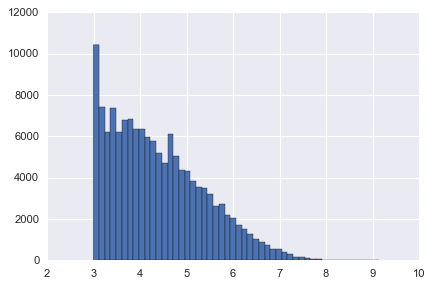

In [70]:
_, _, _ = plt.hist(np.log(user_counts.values), 50)

It looks like we've grabbed the top users' ratings.  There are no users with fewer than 20 ratings. 

##  Creating Categories

In [107]:
ratings['user_codes'] = ratings['userId'].astype('category').cat.codes
ratings['movie_codes'] = ratings['movieId'].astype('category').cat.codes
ratings['rating'] = ratings['rating'].astype(float)

In [82]:
ratings.head()

,userId,movieId,rating,timestamp,title,genres,user_codes,movie_codes
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy,0,1
1,1,29,3.5,1112484676,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,0,28
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0,31
3,1,47,3.5,1112484727,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,46
4,1,50,3.5,1112484580,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0,49


In [98]:
movie_categories = ratings['movieId'].astype('category').cat.categories

Now after we fit a model using `movie_codes`, we can go back and get the corresponding `movieId` with the `.cat.categories` object.

In [101]:
movie_categories[[1,28,31,46,49]]

Int64Index([2, 29, 32, 47, 50], dtype='int64')

In [117]:
movie_ids_df = pd.DataFrame({
    'movieId': movie_categories,
    'movie_codes': range(N_movies)
})

We can also use this dataframe as a way to merge back in learned parameters into the movies dataframe. 

##  Model Definition

Let's go ahead and define our model before we reformat our data.

We will use a vanilla PMF - exactly the one defined above, with predetermined $\Lambda_{\text{movies}} = \Lambda_{\text{users}} = I_K$ and $K=3$.

In [148]:
from edward.models import Normal, PointMass
#  This will need to change if you train/test split
N_users = len(set(ratings.userId))
N_movies = len(set(ratings.movieId))
N_ratings = ratings.shape[0]
K = 2

#  Allow offsets to have differen regularization from latent vecs
#  Offsets
lnvar_user_betas = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))
lnvar_movie_betas = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))

sigma_user_betas = tf.sqrt(tf.exp(lnvar_user_betas))
sigma_movie_betas = tf.sqrt(tf.exp(lnvar_movie_betas))

#  Latent vecs
lnvar_user_vecs = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))
lnvar_movie_vecs = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))

sigma_user_vecs = tf.sqrt(tf.exp(lnvar_user_vecs))
sigma_movie_vecs = tf.sqrt(tf.exp(lnvar_movie_vecs))


user_vecs = Normal(loc = tf.zeros([N_users, K]), 
                   scale = sigma_user_vecs * tf.ones([N_users, K]))
movie_vecs = Normal(loc = tf.zeros([N_movies, K]), 
                    scale = sigma_movie_vecs * tf.ones([N_movies, K]))

#  Somewhat hacky prior on mu
mu = Normal(loc = 2.5*tf.ones([1]), 
            scale = tf.ones([1]))

user_betas = Normal(loc = tf.zeros([N_users]), 
                    scale = sigma_user_betas * tf.ones([N_users]))
movie_betas = Normal(loc = tf.zeros([N_movies]), 
                     scale = sigma_movie_betas * tf.ones([N_movies]))

#  Placeholders for data inputs
user_ids = tf.placeholder(tf.int32, [N_ratings])
movie_ids = tf.placeholder(tf.int32, [N_ratings])

predicted_ratings = tf.reduce_sum(tf.multiply(
    tf.gather(user_vecs, user_ids),
    tf.gather(movie_vecs, movie_ids)
)) + \
    tf.gather(user_betas, user_ids) + \
    tf.gather(movie_betas, movie_ids) + \
    mu

obs_ratings = Normal(loc=predicted_ratings, scale = tf.ones([N_ratings]))

##  Inference Definition

We have now sret up a probablistic graph for generating ratings from our learnable paramters (mu, offsets, and vectors).  We now explicitly define our inference.  Edward makes it easy to swap out sampling, ML, and variational methods.  We'll use simple MFVI.  

In [153]:
# INFERENCE
q_user_vecs = PointMass(tf.Variable(tf.random_normal([N_users, K])))
q_movie_vecs = PointMass(tf.Variable(tf.random_normal([N_movies, K])))


q_user_betas = PointMass(tf.Variable(tf.random_normal([N_users])))
q_movie_betas = PointMass(tf.Variable(tf.random_normal([N_movies])))

q_mu = PointMass(tf.Variable(tf.random_normal([1])))
q_lnvar_users = PointMass(tf.Variable(tf.random_normal([1])))
q_lnvar_movies = PointMass(tf.Variable(tf.random_normal([1])))
                                    
parameter_inferences = {
    user_vecs: q_user_vecs,
    movie_vecs: q_movie_vecs,
    user_betas: q_user_betas,
    movie_betas: q_movie_betas,
    mu: q_mu,
    lnvar_users: q_lnvar_users,
    lnvar_movies: q_lnvar_movies
}
train_data = {
    user_ids: ratings['user_codes'].values,
    movie_ids: ratings['movie_codes'].values,
    obs_ratings: ratings['rating'].values
}

inference = ed.MAP(parameter_inferences,
                   train_data)

#  Run the Inference

We now have everything set up and can let SGD run. 

In [212]:
#optimizer = tf.train.FtrlOptimizer(learning_rate=1e-2)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)
n_iter = 1000
n_print = 20

inference.initialize(optimizer=optimizer, n_print=n_print, n_iter=n_iter)
tf.global_variables_initializer().run()

In [213]:
loss = np.empty(n_iter, dtype=np.float32)
mus = np.empty(n_iter, dtype=np.float32)
movie_offset_sigmas = np.empty(n_iter, dtype=np.float32)
user_offset_sigmas = np.empty(n_iter, dtype=np.float32)
movie_vec_sigmas = np.empty(n_iter, dtype=np.float32)
user_vec_sigmas = np.empty(n_iter, dtype=np.float32)

In [214]:
for i in range(inference.n_iter):
    info_dict = inference.update()
    
    loss[i] = info_dict['loss']
    mus[i] = q_mu.mean().eval()                                                     
    movie_offset_sigmas[i] = np.sqrt(np.exp(q_lnvar_movies.mean().eval()))))
    user_offset_sigmas[i] = np.sqrt(np.exp(q_lnvar_users.mean().eval()))))
    movie_vec_sigmas[i] = np.sqrt(np.exp(q_lnvar_movies.mean().eval()))))
    user_vec_sigmas[i] = np.sqrt(np.exp(q_lnvar_users.mean().eval()))))

    inference.print_progress(info_dict)
    #inference.print_progress(info_dict)
    if info_dict['t'] % inference.n_print == 0:
        l_per_rating = info_dict['loss'] / (1.0 * N_ratings)
        print('Iter: {}    Loss per rating: {} \n'.format(info_dict['t'], l_per_rating))


Iter: 1000    Loss per rating: 2.45882626643 



1000/1000 [100%] ██████████████████████████████ Elapsed: 1241s | Loss: 49177172.000

Iter: 980    Loss per rating: 2.45681309291 



 980/1000 [ 98%] █████████████████████████████  ETA: 24s | Loss: 49136908.000

Iter: 960    Loss per rating: 2.45066977369 



 960/1000 [ 96%] ████████████████████████████   ETA: 49s | Loss: 49014040.000

Iter: 940    Loss per rating: 2.44756521452 



 940/1000 [ 94%] ████████████████████████████   ETA: 74s | Loss: 48951948.000

Iter: 920    Loss per rating: 2.45134436482 



 920/1000 [ 92%] ███████████████████████████    ETA: 99s | Loss: 49027532.000 

Iter: 900    Loss per rating: 2.4496651869 



 900/1000 [ 90%] ███████████████████████████    ETA: 124s | Loss: 48993948.000

Iter: 880    Loss per rating: 2.45103096894 



 880/1000 [ 88%] ██████████████████████████     ETA: 148s | Loss: 49021264.000

Iter: 860    Loss per rating: 2.45002018223 



 860/1000 [ 86%] █████████████████████████      ETA: 172s | Loss: 49001048.000

Iter: 840    Loss per rating: 2.4530191428 



 840/1000 [ 84%] █████████████████████████      ETA: 197s | Loss: 49061028.000

Iter: 820    Loss per rating: 2.44768241298 



 820/1000 [ 82%] ████████████████████████       ETA: 221s | Loss: 48954292.000

Iter: 800    Loss per rating: 2.45699049058 



 800/1000 [ 80%] ████████████████████████       ETA: 246s | Loss: 49140456.000

Iter: 780    Loss per rating: 2.4512243664 



 780/1000 [ 78%] ███████████████████████        ETA: 270s | Loss: 49025132.000

Iter: 760    Loss per rating: 2.45147616309 



 760/1000 [ 76%] ██████████████████████         ETA: 294s | Loss: 49030168.000

Iter: 740    Loss per rating: 2.45346073699 



 740/1000 [ 74%] ██████████████████████         ETA: 319s | Loss: 49069860.000

Iter: 720    Loss per rating: 2.4512473661 



 720/1000 [ 72%] █████████████████████          ETA: 343s | Loss: 49025592.000

Iter: 700    Loss per rating: 2.4767910302 



 700/1000 [ 70%] █████████████████████          ETA: 367s | Loss: 49536472.000

Iter: 680    Loss per rating: 2.46160062995 



 680/1000 [ 68%] ████████████████████           ETA: 389s | Loss: 49232660.000

Iter: 660    Loss per rating: 2.45103176893 



 660/1000 [ 66%] ███████████████████            ETA: 413s | Loss: 49021280.000

Iter: 640    Loss per rating: 2.45106716847 



 640/1000 [ 64%] ███████████████████            ETA: 437s | Loss: 49021988.000

Iter: 620    Loss per rating: 2.47967859223 



 620/1000 [ 62%] ██████████████████             ETA: 462s | Loss: 49594224.000

Iter: 600    Loss per rating: 2.4573838854 



 600/1000 [ 60%] ██████████████████             ETA: 486s | Loss: 49148324.000

Iter: 580    Loss per rating: 2.49457419635 



 580/1000 [ 57%] █████████████████              ETA: 509s | Loss: 49892140.000

Iter: 560    Loss per rating: 2.46137403293 



 560/1000 [ 56%] ████████████████               ETA: 532s | Loss: 49228128.000

Iter: 540    Loss per rating: 2.45632829928 



 540/1000 [ 54%] ████████████████               ETA: 556s | Loss: 49127212.000

Iter: 520    Loss per rating: 2.45417832755 



 520/1000 [ 52%] ███████████████                ETA: 580s | Loss: 49084212.000

Iter: 500    Loss per rating: 2.49568338176 



 500/1000 [ 50%] ███████████████                ETA: 604s | Loss: 49914324.000

Iter: 480    Loss per rating: 2.46884013475 



 480/1000 [ 48%] ██████████████                 ETA: 626s | Loss: 49377452.000

Iter: 460    Loss per rating: 2.45616970137 



 460/1000 [ 46%] █████████████                  ETA: 649s | Loss: 49124040.000

Iter: 440    Loss per rating: 2.4615512306 



 440/1000 [ 44%] █████████████                  ETA: 673s | Loss: 49231672.000

Iter: 420    Loss per rating: 2.45431132581 



 420/1000 [ 42%] ████████████                   ETA: 696s | Loss: 49086872.000

Iter: 400    Loss per rating: 2.46824854253 



 400/1000 [ 40%] ████████████                   ETA: 720s | Loss: 49365620.000

Iter: 380    Loss per rating: 2.45826527381 



 380/1000 [ 38%] ███████████                    ETA: 743s | Loss: 49165952.000

Iter: 360    Loss per rating: 2.45894466488 



 360/1000 [ 36%] ██████████                     ETA: 766s | Loss: 49179540.000

Iter: 340    Loss per rating: 2.45557890914 



 340/1000 [ 34%] ██████████                     ETA: 789s | Loss: 49112224.000

Iter: 320    Loss per rating: 2.45575790678 



 320/1000 [ 32%] █████████                      ETA: 812s | Loss: 49115804.000

Iter: 300    Loss per rating: 2.45474912005 



 300/1000 [ 30%] █████████                      ETA: 836s | Loss: 49095628.000

Iter: 280    Loss per rating: 2.45571590734 



 280/1000 [ 28%] ████████                       ETA: 860s | Loss: 49114964.000

Iter: 260    Loss per rating: 2.45753848337 



 260/1000 [ 26%] ███████                        ETA: 888s | Loss: 49151416.000

Iter: 240    Loss per rating: 2.46139563265 



 240/1000 [ 24%] ███████                        ETA: 917s | Loss: 49228560.000

Iter: 220    Loss per rating: 2.46043944522 



 220/1000 [ 22%] ██████                         ETA: 947s | Loss: 49209436.000

Iter: 200    Loss per rating: 2.52313562077 



 200/1000 [ 20%] ██████                         ETA: 979s | Loss: 50463376.000

Iter: 180    Loss per rating: 4.57305026439 



 180/1000 [ 18%] █████                          ETA: 1011s | Loss: 91462208.000

Iter: 160    Loss per rating: 2.46316980932 



 160/1000 [ 16%] ████                           ETA: 1044s | Loss: 49264044.000  

Iter: 140    Loss per rating: 88.9216530803 



 140/1000 [ 14%] ████                           ETA: 1078s | Loss: 1778456448.000

Iter: 120    Loss per rating: 927.706507859 



 120/1000 [ 12%] ███                            ETA: 1120s | Loss: 18554374144.000

Iter: 100    Loss per rating: 4752.39318603 



 100/1000 [ 10%] ███                            ETA: 1158s | Loss: 95049113600.000

Iter: 80    Loss per rating: 6519.63215484 



  80/1000 [  8%] ██                             ETA: 1198s | Loss: 130394357760.000

Iter: 60    Loss per rating: 157086.966089 



  60/1000 [  6%] █                              ETA: 1239s | Loss: 3141780635648.000 

Iter: 40    Loss per rating: 690371.210438 



  40/1000 [  4%] █                              ETA: 1305s | Loss: 13807605776384.000

Iter: 20    Loss per rating: 12550017.9743 



  20/1000 [  2%]                                ETA: 1445s | Loss: 251003660140544.000

   1/1000 [  0%]                                ETA: 7256s | Loss: 51618032648192.000

This plot taken directly from [Dada Romeo's excellent HPF post](https://github.com/dadaromeo/recsys-hpf).

In [221]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.plot(np.log(loss / loss.max())
ax.set_title("Loss")
ax.set_xlabel("Iteration")
ax.set_ylabel("Log(loss / maximum loss)")
savefig("loss_is_converging.png")

#  Model Criticism

Great!  It looks like now (after switching from klpq to MAP) we are at least converging.  

Just as a first sanity check, let's see which movies the model thinks are best. 

Before we even do that, let's see what movies have the highest avg ratings.  Just to see if it makes sense if we start to see the model disagree with our guesses of what should be in the top 5-10.

In [222]:
mean_ratings = ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)
mean_ratings = mean_ratings.to_frame()
mean_ratings.head()

         rating
movieId        
117606      5.0
88488       5.0
130996      5.0
54326       5.0
121039      5.0

In [223]:
mean_ratings['movieId'] = mean_ratings.index.values

In [224]:
mean_ratings.columns

Index([u'rating', u'movieId'], dtype='object')

In [225]:
fit_movie_means = q_movie_betas.mean().eval()
movie_ids_df['fit_beta'] = fit_movie_means
movie_betas_df = movie_ids_df.merge(movies, on = 'movieId', how='left')
movie_betas_df.sort_values(['movieId'])

       movieId  movie_codes  fit_beta  \
0            1            0  0.461622   
1            2            1  0.249863   
2            3            2 -0.054654   
3            4            3  0.732326   
4            5            4  1.023908   
5            6            5 -0.353033   
6            7            6  0.375475   
7            8            7  0.448393   
8            9            8  2.143444   
9           10            9 -1.277060   
10          11           10  0.382169   
11          12           11 -0.281702   
12          13           12 -0.032711   
13          14           13 -0.798523   
14          15           14  1.124039   
15          16           15 -0.384937   
16          17           16 -1.491746   
17          18           17 -0.743767   
18          19           18  0.628125   
19          20           19 -1.039030   
20          21           20 -0.626473   
21          22           21 -0.498214   
22          23           22 -1.042925   
23          24  

In [226]:
print(mean_ratings.head())
print(movie_betas_df.head())
print(mean_ratings.shape)
print(movie_betas_df.shape)

         rating  movieId
movieId                 
117606      5.0   117606
88488       5.0    88488
130996      5.0   130996
54326       5.0    54326
121039      5.0   121039
   movieId  movie_codes  fit_beta                               title  \
0        1            0  0.461622                    Toy Story (1995)   
1        2            1  0.249863                      Jumanji (1995)   
2        3            2 -0.054654             Grumpier Old Men (1995)   
3        4            3  0.732326            Waiting to Exhale (1995)   
4        5            4  1.023908  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
(26744, 2)
(26744, 5)


In [227]:
movie_betas_df = movie_betas_df.merge(mean_ratings,
                                      left_on = 'movieId', 
                                      right_on = 'movieId')
movie_betas_df.sort_values(['movieId']).head()

   movieId  movie_codes  fit_beta                               title  \
0        1            0  0.461622                    Toy Story (1995)   
1        2            1  0.249863                      Jumanji (1995)   
2        3            2 -0.054654             Grumpier Old Men (1995)   
3        4            3  0.732326            Waiting to Exhale (1995)   
4        5            4  1.023908  Father of the Bride Part II (1995)   

                                        genres    rating  
0  Adventure|Animation|Children|Comedy|Fantasy  3.921240  
1                   Adventure|Children|Fantasy  3.211977  
2                               Comedy|Romance  3.151040  
3                         Comedy|Drama|Romance  2.861393  
4                                       Comedy  3.064592  

In [228]:
movie_betas_df.sort_values(['fit_beta'], ascending=False).head(5)

       movieId  movie_codes  fit_beta  \
13648    68222        13648  3.898041   
8412     25829         8412  3.800530   
16406    83004        16406  3.757703   
7786      8385         7786  3.750921   
14046    70593        14046  3.688565   

                                                   title  \
13648  Final Inquiry, The (Inquiry, The) (inchiesta, ...   
8412                        Revolt of the Zombies (1936)   
16406                              Tere Bin Laden (2010)   
7786                              Lover Come Back (1961)   
14046                        Dillinger and Capone (1995)   

                        genres    rating  
13648  Adventure|Drama|Mystery  2.500000  
8412                Horror|War  1.214286  
16406             Comedy|Drama  4.111111  
7786            Comedy|Romance  3.636986  
14046              Crime|Drama  3.000000  

In [229]:
plt.scatter(movie_betas_df['rating'].values, movie_betas_df['fit_beta'].values,
            s = 0.05)

There appears to be no relation at all b/w fit betas and mean ratings. I must be making a mistake in the movie ID matching. 

It pretty clearly looks to me like the model is not yet finding ratings make much sense.  It's also pretty clear the infernce is not converging.  I'm going to allow betas and latent vecs to have different regularizations and will rerun.  

Let's also check the other learned parameters to see if they make sense.

In [234]:
print('Mu is at {}'.format(q_mu.mean().eval()))

print('Sigma for movies is at {}'.format(np.sqrt(np.exp(q_lnvar_users.mean().eval()))))
print('Sigma for users is at {}'.format(np.sqrt(np.exp(q_lnvar_movies.mean().eval()))))

Mu is at [-0.68204719]
Sigma for movies is at [ 1.]
Sigma for users is at [ 1.]


Something is obviously wrong if the mu is negative.

In [163]:
ratings['rating'].value_counts()

4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: rating, dtype: int64

We can also check out the distribution of fit offsets for movies. Nothing too concerning.

In [197]:
_, _, _ = plt.hist(fit_movie_means, 30)

#  Visualizing the Latent Dimensions

Now let's see if the factorization has learned meaningfull embeddings.

First let's pick a small subset of the movies to plot.

In [ ]:
movie_counts = ratings['movieId'].value_counts()